Overview

The goal is to create an energy prediction model of prosumers to reduce energy imbalance costs.

This notebook aims to tackle the issue of energy imbalance, a situation where the energy expected to be used doesn't line up with the actual energy used or produced. Prosumers, who both consume and generate energy, contribute a large part of the energy imbalance. Despite being only a small part of all consumers, their unpredictable energy use causes logistical and financial problems for the energy compan

Description

The number of prosumers is rapidly increasing, and solving the problems of energy imbalance and their rising costs is vital. If left unaddressed, this could lead to increased operational costs, potential grid instability, and inefficient use of energy resources. If this problem were effectively solved, it would significantly reduce the imbalance costs, improve the reliability of the grid, and make the integration of prosumers into the energy system more efficient and sustainable. Moreover, it could potentially incentivize more consumers to become prosumers, knowing that their energy behavior can be adequately managed, thus promoting renewable energy production and us

Dataset Description

Your challenge in this competition is to predict the amount of electricity produced and consumed by Estonian energy customers who have installed solar panels. You'll have access to weather data, the relevant energy prices, and records of the installed photovoltaic capacity.

This is a forecasting competition using the time series API. The private leaderboard will be determined using real data gathered after the submission period closes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from datetime import date, timedelta
import seaborn as sns
import zipp
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.datasets import make_regression
from sklearnex import patch_sklearn, config_context

from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import pickle


from xgboost import XGBRegressor

from mpl_toolkits.basemap import Basemap

import tensorflow as tf

from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

2024-01-30 18:31:55.423216: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-30 18:31:55.443798: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 18:31:55.443817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 18:31:55.444355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 18:31:55.448273: I tensorflow/core/platform/cpu_feature_guar

# Open the files

In [2]:
#Read the client data
df_client = pd.read_csv("predict-energy-behavior-of-prosumers/client.csv")
df_client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [3]:
df_client[(df_client['date'] == "2022-12-02") & (df_client['county'] == 3)]

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
30037,1,3,36,395.20,0,2022-12-02,459
30038,3,3,99,1298.43,0,2022-12-02,459
30039,1,3,10,133.10,1,2022-12-02,459
30040,3,3,50,2749.20,1,2022-12-02,459


In [4]:
df_client['data_block_id'].max()

637

In [5]:
df_client['data_block_id'].nunique()

636

In [6]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_type        41919 non-null  int64  
 1   county              41919 non-null  int64  
 2   eic_count           41919 non-null  int64  
 3   installed_capacity  41919 non-null  float64
 4   is_business         41919 non-null  int64  
 5   date                41919 non-null  object 
 6   data_block_id       41919 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.2+ MB


In [7]:
#Read the training data
df = pd.read_csv("predict-energy-behavior-of-prosumers/train.csv")
df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [8]:
n_customers = df['prediction_unit_id'].nunique()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


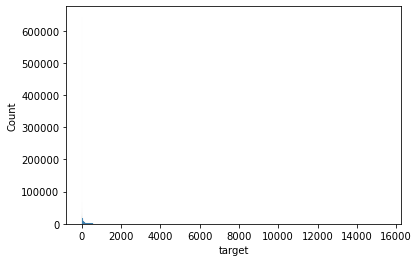

In [10]:
sns.histplot(data=df, x='target')
plt.show()

In [11]:
df.shape

(2018352, 9)

In [12]:
df.describe()

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id
count,2.018352e+06,2.018352e+06,2.018352e+06,2.017824e+06,2018352.0,2.018352e+06,2.018352e+06,2.018352e+06
mean,7.297034e+00,5.368261e-01,1.898927e+00,2.748556e+02,0.5,3.218746e+02,1.009176e+06,3.304538e+01
std,4.780990e+00,4.986421e-01,1.081766e+00,9.095024e+02,0.5,1.826343e+02,5.826482e+05,1.959059e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,1.000000e+00,3.780000e-01,0.0,1.660000e+02,5.045878e+05,1.600000e+01
50%,7.000000e+00,1.000000e+00,2.000000e+00,3.113300e+01,0.5,3.230000e+02,1.009176e+06,3.300000e+01
75%,1.100000e+01,1.000000e+00,3.000000e+00,1.802062e+02,1.0,4.790000e+02,1.513763e+06,5.000000e+01
max,1.500000e+01,1.000000e+00,3.000000e+00,1.548027e+04,1.0,6.370000e+02,2.018351e+06,6.800000e+01


In [13]:
#Get all the unique prediction_unit_id, total 69.
df_location_data = df[['county','is_business','product_type','prediction_unit_id']].drop_duplicates()
df_location_data.head()

,county,is_business,product_type,prediction_unit_id
0,0,0,1,0
2,0,0,2,1
4,0,0,3,2
6,0,1,0,3
8,0,1,1,4


In [14]:
#Add prediction_unit_id column in client dataframe. IS THIS CORRECT????
df_client = pd.merge(df_client, df_location_data[['county', 'is_business', 'product_type', 'prediction_unit_id']], on=['county', 'is_business', 'product_type'], how='left')
df_client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id,prediction_unit_id
0,1,0,108,952.89,0,2021-09-01,2,0
1,2,0,17,166.40,0,2021-09-01,2,1
2,3,0,688,7207.88,0,2021-09-01,2,2
3,0,0,5,400.00,1,2021-09-01,2,3
4,1,0,43,1411.00,1,2021-09-01,2,4


In [15]:
df_client[(df_client['date'] == "2022-12-02") & (df_client['county'] == 3)]

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id,prediction_unit_id
30037,1,3,36,395.20,0,2022-12-02,459,11
30038,3,3,99,1298.43,0,2022-12-02,459,12
30039,1,3,10,133.10,1,2022-12-02,459,13
30040,3,3,50,2749.20,1,2022-12-02,459,14


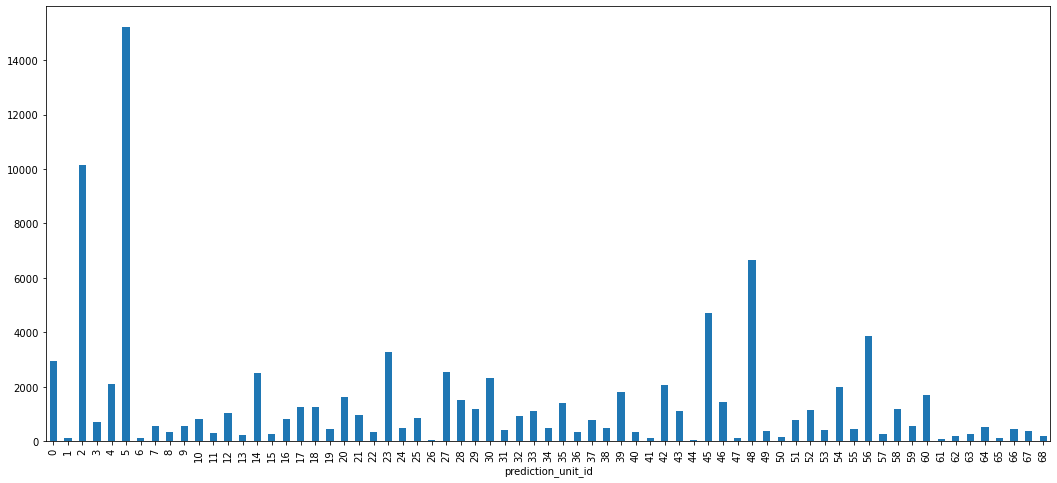

In [16]:
#Mean installaed capacity of each prosumer. (county, is_business, and product_type = prediction_unit_id).
plt.figure(figsize=(18, 8))
df_client.groupby(['prediction_unit_id'])['installed_capacity'].mean().plot(kind='bar')
plt.show()

In [17]:
#Change the date to datetime and separate time of the day
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime-1d'] = df['datetime'] - timedelta(days=1)
df['date'] = pd.to_datetime(df['datetime']).dt.date
df['time'] = pd.to_datetime(df['datetime']).dt.hour
df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,datetime-1d,date,time
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-08-31,2021-09-01,0
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-08-31,2021-09-01,0
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021-08-31,2021-09-01,0
3,0,0,2,17.314,1,2021-09-01,0,3,1,2021-08-31,2021-09-01,0
4,0,0,3,2.904,0,2021-09-01,0,4,2,2021-08-31,2021-09-01,0


<AxesSubplot:xlabel='county'>

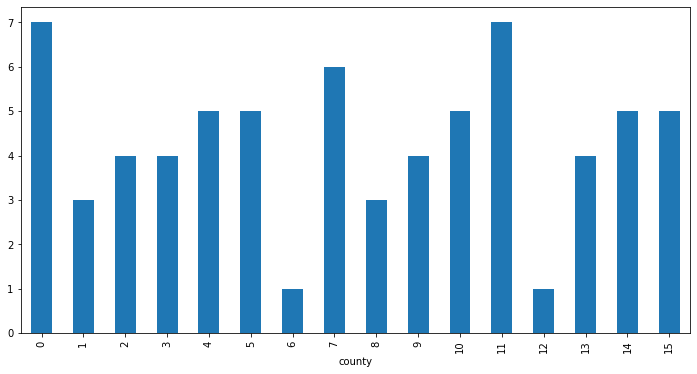

In [18]:
#Check the distribution of unique prediction units at each county
plt.figure(figsize=(12, 6))
df.groupby(['county'])['prediction_unit_id'].nunique().plot(kind='bar')

In [19]:
#Read the gas price data
df_gas = pd.read_csv("predict-energy-behavior-of-prosumers/gas_prices.csv")
df_gas.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [20]:
#Change the date to datetime
df_gas['forecast_date'] = pd.to_datetime(df_gas['forecast_date'])
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   forecast_date          637 non-null    datetime64[ns]
 1   lowest_price_per_mwh   637 non-null    float64       
 2   highest_price_per_mwh  637 non-null    float64       
 3   origin_date            637 non-null    object        
 4   data_block_id          637 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 25.0+ KB


In [21]:
df_gas['origin_date'].max()

'2023-05-29'

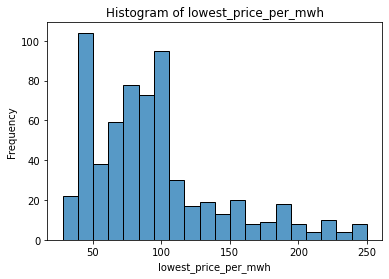

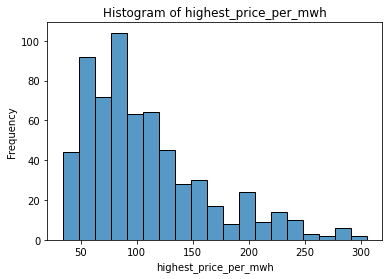

In [22]:
# Select columns with dtype float64
float_columns = df_gas.select_dtypes(include=['float64']).columns

# Iterate over these columns to create histograms
for col in float_columns:
    sns.histplot(df_gas[col])
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


In [23]:
#Read the electricity price data, GET TIME OF THE DAY IN SEPARATE COLUMN
df_el = pd.read_csv("predict-energy-behavior-of-prosumers/electricity_prices.csv")
df_el.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [24]:
df_el[(df_el['forecast_date'] == "2022-12-02 02:00:00")]

,forecast_date,euros_per_mwh,origin_date,data_block_id
10969,2022-12-02 02:00:00,303.04,2022-12-01 02:00:00,458


In [25]:
df_gas['forecast_date'].max()

Timestamp('2023-05-30 00:00:00')

In [26]:
#Change the date to datetime and separate time of the day
df_el['origin_date'] = pd.to_datetime(df_el['origin_date'])
#df_el['time'] = df_el['forecast_date'].dt.time
df_el['time'] = pd.to_datetime(df_el['forecast_date']).dt.hour
df_el.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id,time
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1,0
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1,2
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1,3
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1,4


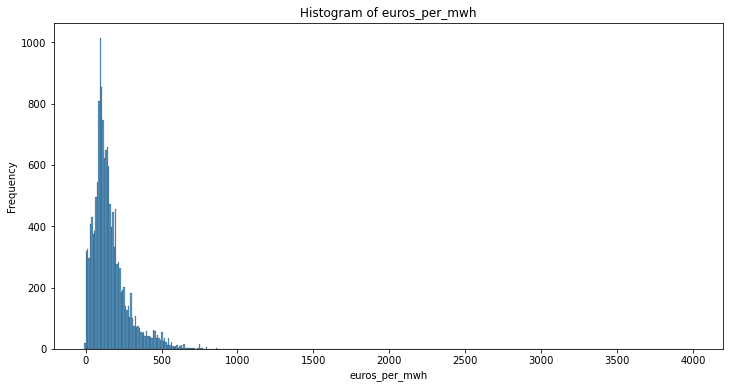

In [27]:
plt.figure(figsize=(12, 6))
# Select columns with dtype float64
float_columns = df_el.select_dtypes(include=['float64']).columns

# Iterate over these columns to create histograms
for col in float_columns:
    sns.histplot(df_el[col])
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [28]:
#Read the hourly weather forecast data
df_fwe = pd.read_csv("predict-energy-behavior-of-prosumers/forecast_weather.csv")
df_fwe.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


In [29]:
df_fwe_new = pd.read_csv("predict-energy-behavior-of-prosumers/forecast_weather_new.csv")
df_fwe_new.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


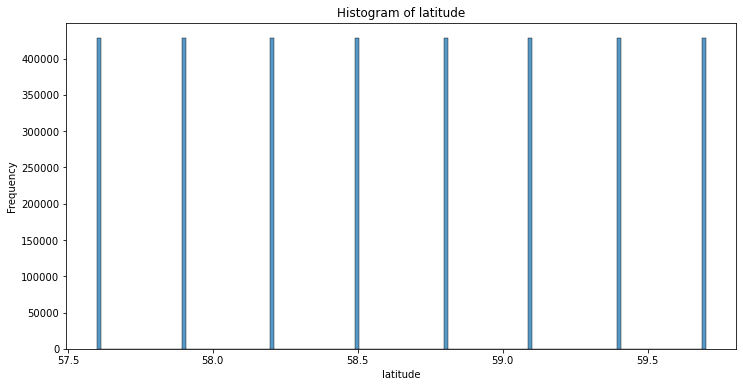

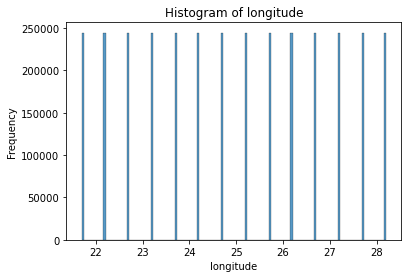

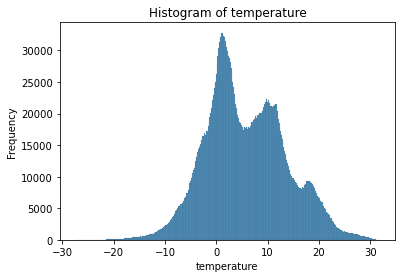

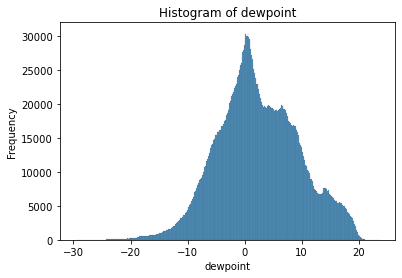

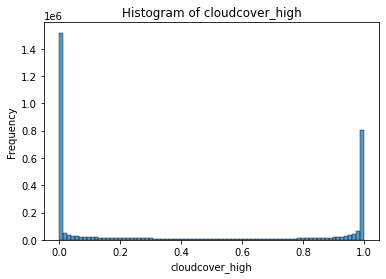

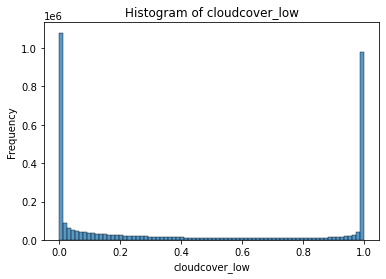

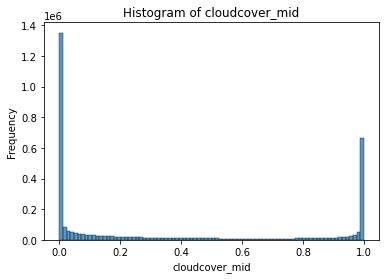

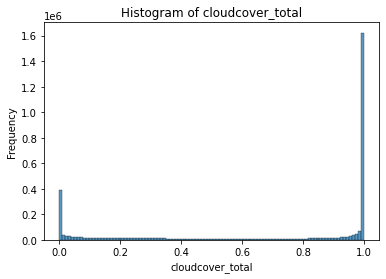

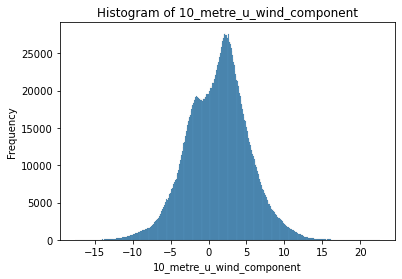

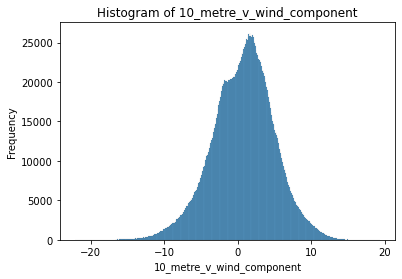

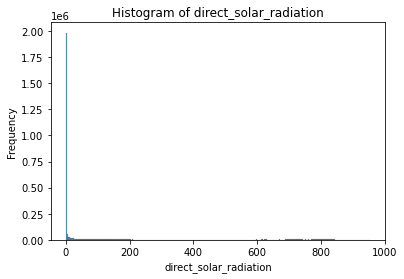

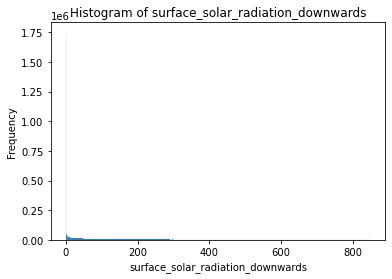

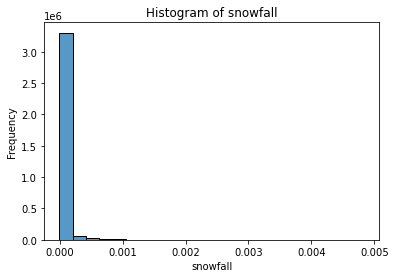

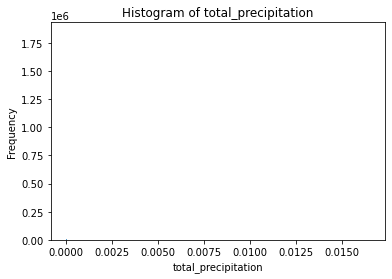

In [30]:
plt.figure(figsize=(12, 6))
# Select columns with dtype float64
float_columns = df_fwe.select_dtypes(include=['float64']).columns

# Iterate over these columns to create histograms
for col in float_columns:
    sns.histplot(df_fwe[col])
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [31]:
#Read the historical weather data. COMPARE HOW WEEL FORECAST AND ACTUAL WEATHER MATCH.
df_hwe = pd.read_csv("predict-energy-behavior-of-prosumers/historical_weather.csv")
df_hwe.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


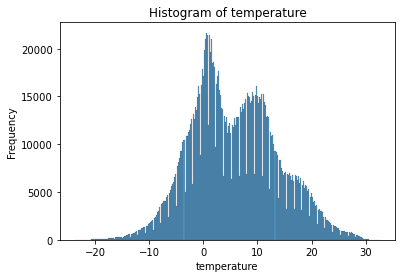

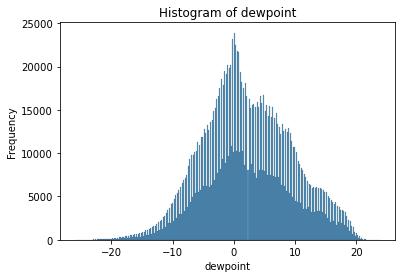

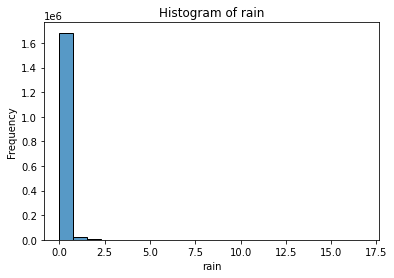

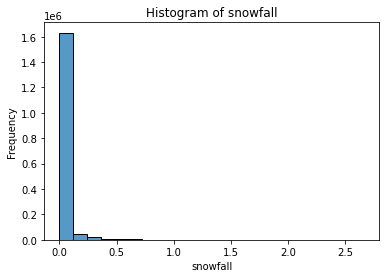

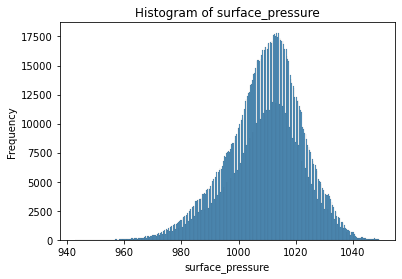

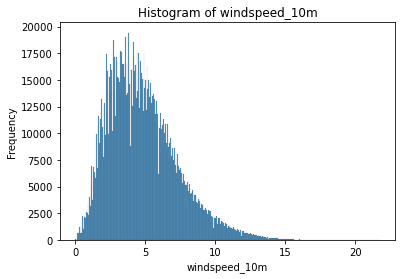

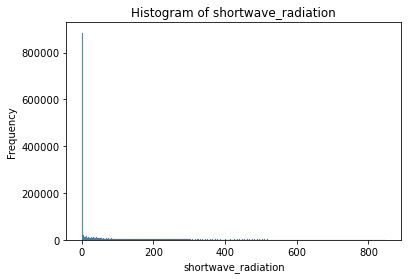

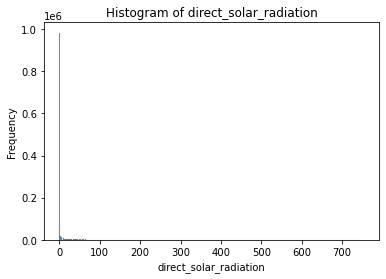

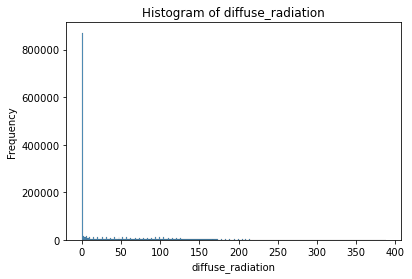

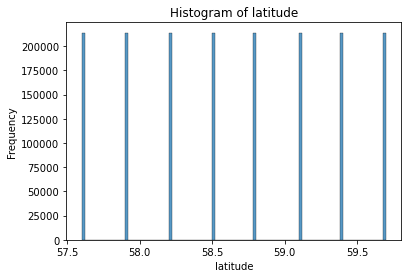

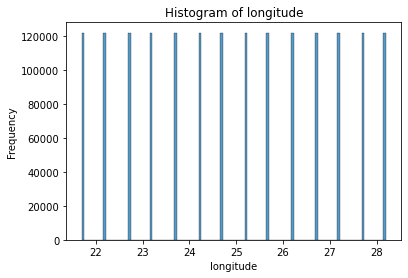

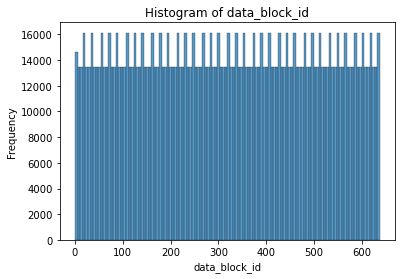

In [32]:
# Select columns with dtype float64
float_columns = df_hwe.select_dtypes(include=['float64']).columns

# Iterate over these columns to create histograms
for col in float_columns:
    sns.histplot(df_hwe[col])
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [33]:
df_fwe.shape

(3424512, 18)

In [34]:
df_hwe.shape

(1710802, 18)

In [35]:
df_fwe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   latitude                           float64
 1   longitude                          float64
 2   origin_datetime                    object 
 3   hours_ahead                        int64  
 4   temperature                        float64
 5   dewpoint                           float64
 6   cloudcover_high                    float64
 7   cloudcover_low                     float64
 8   cloudcover_mid                     float64
 9   cloudcover_total                   float64
 10  10_metre_u_wind_component          float64
 11  10_metre_v_wind_component          float64
 12  data_block_id                      int64  
 13  forecast_datetime                  object 
 14  direct_solar_radiation             float64
 15  surface_solar_radiation_downwards  float64
 16  snowfall          

In [36]:
df_hwe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710802 entries, 0 to 1710801
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   datetime                object 
 1   temperature             float64
 2   dewpoint                float64
 3   rain                    float64
 4   snowfall                float64
 5   surface_pressure        float64
 6   cloudcover_total        int64  
 7   cloudcover_low          int64  
 8   cloudcover_mid          int64  
 9   cloudcover_high         int64  
 10  windspeed_10m           float64
 11  winddirection_10m       int64  
 12  shortwave_radiation     float64
 13  direct_solar_radiation  float64
 14  diffuse_radiation       float64
 15  latitude                float64
 16  longitude               float64
 17  data_block_id           float64
dtypes: float64(12), int64(5), object(1)
memory usage: 234.9+ MB


In [37]:
#Changes time stamps to match local times

#df_fwe['origin_datetime'] = pd.to_datetime(df_fwe['origin_datetime'])
#df_fwe['forecast_datetime'] = pd.to_datetime(df_fwe['forecast_datetime'])
#df_hwe['datetime'] = pd.to_datetime(df_hwe['datetime'])

#df_fwe['origin_datetime'] = df_fwe['origin_datetime'].dt.tz_convert('Europe/Tallinn')
#df_fwe['forecast_datetime'] = df_fwe['forecast_datetime'].dt.tz_convert('Europe/Tallinn')

#df_fwe['origin_datetime'] = df_fwe['origin_datetime'].dt.tz_localize(None)
#df_fwe['forecast_datetime'] = df_fwe['forecast_datetime'].dt.tz_localize(None)

In [38]:
common_columns = df_fwe.columns.intersection(df_hwe.columns)
common_columns

Index(['latitude', 'longitude', 'temperature', 'dewpoint', 'cloudcover_high',
       'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', 'data_block_id',
       'direct_solar_radiation', 'snowfall'],
      dtype='object')

In [39]:
# Elements to remove for merging files
elements_to_remove = {'latitude', 'longitude'} #removed 'data_block_id' on 1/8/24

# Use list comprehension to filter out the elements
filtered_columns = [col for col in common_columns if col not in elements_to_remove]
filtered_columns

['temperature',
 'dewpoint',
 'cloudcover_high',
 'cloudcover_low',
 'cloudcover_mid',
 'cloudcover_total',
 'data_block_id',
 'direct_solar_radiation',
 'snowfall']

In [40]:
# Create a dictionary with the old names as keys and new names as values
rename_map = {col: 'm_' + col for col in filtered_columns}

# Rename the columns in df_hwe
df_hwe.rename(columns=rename_map, inplace=True)
df_hwe.head()

,datetime,m_temperature,m_dewpoint,rain,m_snowfall,surface_pressure,m_cloudcover_total,m_cloudcover_low,m_cloudcover_mid,m_cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,m_direct_solar_radiation,diffuse_radiation,latitude,longitude,m_data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


In [41]:
df_hwe.shape

(1710802, 18)

In [42]:
#Merge weather data. Look for duplicates and remove before joining the dataframes
df_fwe.drop_duplicates(subset=['latitude', 'longitude', 'forecast_datetime'], inplace=True)
all_weather = df_hwe.merge(df_fwe, left_on=['datetime','latitude','longitude'], right_on=['forecast_datetime','latitude','longitude'], how='inner')
all_weather.head()

,datetime,m_temperature,m_dewpoint,rain,m_snowfall,surface_pressure,m_cloudcover_total,m_cloudcover_low,m_cloudcover_mid,m_cloudcover_high,...,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,2021-09-01 03:00:00,14.3,11.2,0.0,0.0,1016.0,34,21,1,49,...,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,2021-09-01 03:00:00,13.7,11.0,0.0,0.0,1010.7,26,15,0,40,...,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,2021-09-01 03:00:00,13.8,11.7,0.0,0.0,1014.9,39,27,0,48,...,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,2021-09-01 03:00:00,14.1,7.2,0.0,0.0,1018.0,0,0,0,0,...,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,2021-09-01 03:00:00,15.6,13.2,0.0,0.0,1013.6,76,65,1,57,...,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


In [43]:
all_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710242 entries, 0 to 1710241
Data columns (total 34 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   datetime                           object 
 1   m_temperature                      float64
 2   m_dewpoint                         float64
 3   rain                               float64
 4   m_snowfall                         float64
 5   surface_pressure                   float64
 6   m_cloudcover_total                 int64  
 7   m_cloudcover_low                   int64  
 8   m_cloudcover_mid                   int64  
 9   m_cloudcover_high                  int64  
 10  windspeed_10m                      float64
 11  winddirection_10m                  int64  
 12  shortwave_radiation                float64
 13  m_direct_solar_radiation           float64
 14  diffuse_radiation                  float64
 15  latitude                           float64
 16  longitude         

In [44]:
all_weather.isnull().sum()

datetime                             0
m_temperature                        0
m_dewpoint                           0
rain                                 0
m_snowfall                           0
surface_pressure                     0
m_cloudcover_total                   0
m_cloudcover_low                     0
m_cloudcover_mid                     0
m_cloudcover_high                    0
windspeed_10m                        0
winddirection_10m                    0
shortwave_radiation                  0
m_direct_solar_radiation             0
diffuse_radiation                    0
latitude                             0
longitude                            0
m_data_block_id                      0
origin_datetime                      0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total         

In [45]:
all_weather.keys()

Index(['datetime', 'm_temperature', 'm_dewpoint', 'rain', 'm_snowfall',
       'surface_pressure', 'm_cloudcover_total', 'm_cloudcover_low',
       'm_cloudcover_mid', 'm_cloudcover_high', 'windspeed_10m',
       'winddirection_10m', 'shortwave_radiation', 'm_direct_solar_radiation',
       'diffuse_radiation', 'latitude', 'longitude', 'm_data_block_id',
       'origin_datetime', 'hours_ahead', 'temperature', 'dewpoint',
       'cloudcover_high', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 'data_block_id', 'forecast_datetime',
       'direct_solar_radiation', 'surface_solar_radiation_downwards',
       'snowfall', 'total_precipitation'],
      dtype='object')

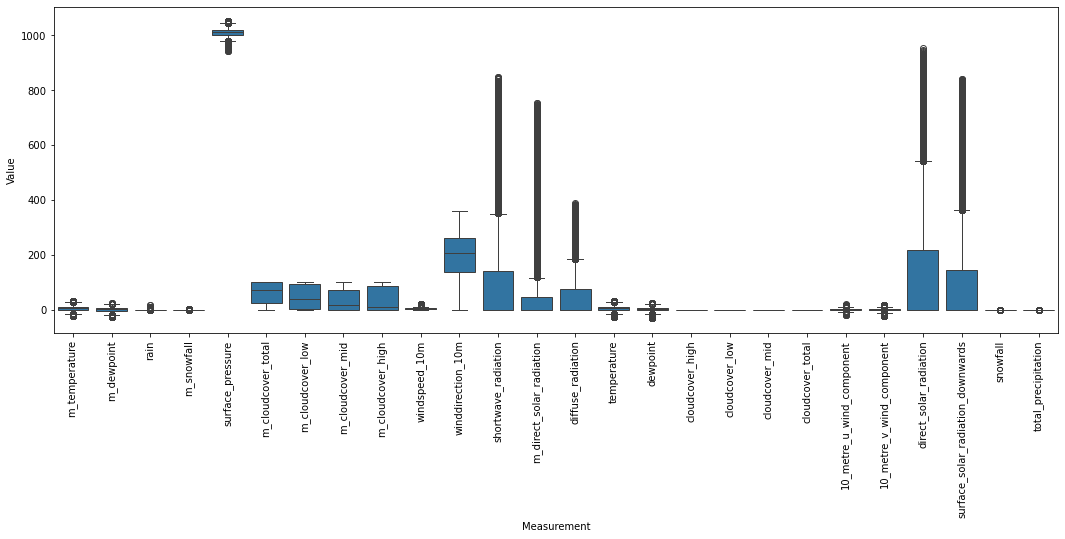

In [46]:
measurements = ['m_temperature', 'm_dewpoint', 'rain', 'm_snowfall',
                'surface_pressure', 'm_cloudcover_total', 'm_cloudcover_low',
                'm_cloudcover_mid', 'm_cloudcover_high', 'windspeed_10m',
                'winddirection_10m', 'shortwave_radiation', 'm_direct_solar_radiation',
                'diffuse_radiation', 'temperature', 'dewpoint', 'cloudcover_high',
                'cloudcover_low', 'cloudcover_mid', 'cloudcover_total',
                '10_metre_u_wind_component', '10_metre_v_wind_component',
                'direct_solar_radiation', 'surface_solar_radiation_downwards',
                'snowfall', 'total_precipitation']
melted_weather = pd.melt(all_weather, id_vars=['datetime'], value_vars=measurements, var_name='Measurement', value_name='Value')
# Creating a boxplot
plt.figure(figsize=(18, 6))  # Adjust the size as needed
sns.boxplot(x='Measurement', y='Value', data=melted_weather)
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.show()

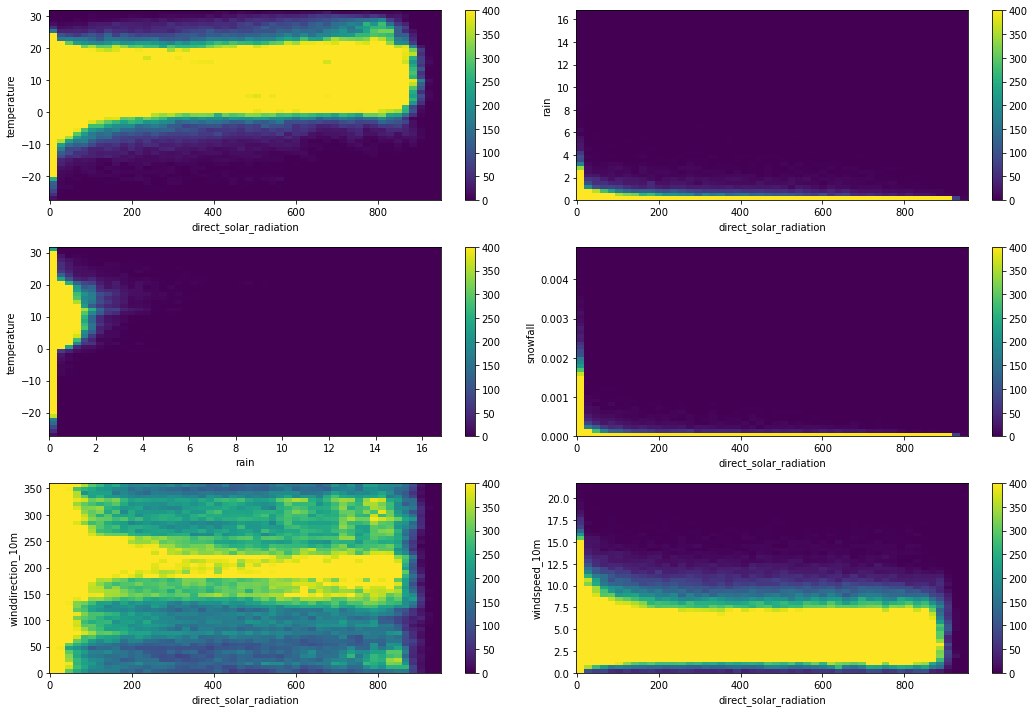

In [47]:
import matplotlib.pyplot as plt

# Define the pairs of features you want to plot
feature_pairs = [
    ('direct_solar_radiation', 'temperature'),
    ('direct_solar_radiation', 'rain'),
    ('rain', 'temperature'),
    ('direct_solar_radiation', 'snowfall'),
    ('direct_solar_radiation', 'winddirection_10m'),
    ('direct_solar_radiation', 'windspeed_10m')
]

# Create a 3x2 matrix of plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))  # Adjust figsize as needed

for ax, (feature_x, feature_y) in zip(axes.flatten(), feature_pairs):
    # Create a 2D histogram in each subplot
    h = ax.hist2d(all_weather[feature_x], all_weather[feature_y], bins=(50, 50), vmax=400)
    fig.colorbar(h[3], ax=ax)
    ax.set_xlabel(f'{feature_x}')
    ax.set_ylabel(f'{feature_y}')
    ax.axis('tight')

plt.tight_layout()
plt.show()


In [48]:
#Read the county to prosumer mapping data
df_wcmap = pd.read_csv("predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv")
df_wcmap.head()

,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN


In [49]:
#Make coordinates matching format on both dataframes
df_fwe['longitude'] = df_fwe['longitude'].round(1)
df_fwe['latitude'] = df_fwe['latitude'].round(1)
all_weather['longitude'] = all_weather['longitude'].round(1)
all_weather['latitude'] = all_weather['latitude'].round(1)

df_wcmap['longitude'] = df_wcmap['longitude'].round(1)
df_wcmap['latitude'] = df_wcmap['latitude'].round(1)

In [50]:
#Drop any null values
df_wcmap.dropna(inplace=True)
df_wcmap = df_wcmap[[col for col in df_wcmap.columns if col != 'county_name'] + ['county_name']]
df_wcmap = df_wcmap[['latitude'] + [col for col in df_wcmap.columns if col != 'latitude']] 


In [51]:
df_wcmap.head()

,latitude,longitude,county,county_name
10,58.2,22.2,10.0,Saaremaa
11,58.5,22.2,10.0,Saaremaa
19,58.5,22.7,10.0,Saaremaa
20,58.8,22.7,1.0,Hiiumaa
27,58.5,23.2,10.0,Saaremaa


# Join the dataframe columns

In [52]:
#Join weather and county mapping using coordinates.
df_fwe1 = pd.merge(all_weather, df_wcmap[['longitude', 'latitude', 'county']], on=['longitude', 'latitude'], how='left')
df_fwe1.head()

,datetime,m_temperature,m_dewpoint,rain,m_snowfall,surface_pressure,m_cloudcover_total,m_cloudcover_low,m_cloudcover_mid,m_cloudcover_high,...,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,county
0,2021-09-01 03:00:00,14.3,11.2,0.0,0.0,1016.0,34,21,1,49,...,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN
1,2021-09-01 03:00:00,13.7,11.0,0.0,0.0,1010.7,26,15,0,40,...,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN
2,2021-09-01 03:00:00,13.8,11.7,0.0,0.0,1014.9,39,27,0,48,...,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN
3,2021-09-01 03:00:00,14.1,7.2,0.0,0.0,1018.0,0,0,0,0,...,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN
4,2021-09-01 03:00:00,15.6,13.2,0.0,0.0,1013.6,76,65,1,57,...,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,NaN


In [53]:
df_fwe1[(df_fwe1['forecast_datetime'] == '2022-12-02 02:00:00') & (df_fwe1['county'] == 3)]

,datetime,m_temperature,m_dewpoint,rain,m_snowfall,surface_pressure,m_cloudcover_total,m_cloudcover_low,m_cloudcover_mid,m_cloudcover_high,...,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,county
1228257,2022-12-02 02:00:00,-7.7,-9.7,0.0,0.0,1027.4,46,19,0,98,...,0.999998,-3.225374,0.277774,457,2022-12-02 02:00:00,0.0,0.0,0.000000,0.0,3.0
1228258,2022-12-02 02:00:00,-8.7,-10.4,0.0,0.0,1028.2,44,16,0,99,...,0.999991,-2.796175,0.432315,457,2022-12-02 02:00:00,0.0,0.0,0.000000,0.0,3.0
1228272,2022-12-02 02:00:00,-7.7,-9.3,0.0,0.0,1026.1,84,60,0,99,...,0.999998,-2.344759,0.608829,457,2022-12-02 02:00:00,0.0,0.0,0.000002,0.0,3.0


In [54]:
#Drop any null values from weather forecast. This is for coordinates with no county assignment. IS THIS CORRECT PLACE?
df_fwe1.dropna(inplace=True)
df_fwe1.shape

(748230, 35)

In [55]:
# Extract the data we're interested in
def get_map_data(df1):
    #lat = df1['latitude'].values
    lat = df1.iloc[:,0].values
    #lon = df1['longitude'].values
    lon = df1.iloc[:,1].values
    county = df1['county'].values
    return lat, lon, county

In [56]:
# 1. Draw the map background
def map_it(lati, long, cnty):
    fig = plt.figure(figsize=(8, 8))
    m = Basemap(projection='lcc', resolution='i', 
            lat_0=58.5, lon_0=25,
            width=0.5E6, height=0.5E6)
    m.shadedrelief()
    m.drawcoastlines(color='gray')
    m.drawcountries(color='gray')
    m.drawstates(color='gray')

    m.scatter(long, lati, latlon=True,
          s=(cnty+3)*3, 
          c=cnty,
          cmap='viridis', alpha=0.9)

    for i in range(len(lat)): 
        plt.plot(long[i], lati[i], 'ok')
        plt.text(long[i], lati[i], cnty[i], fontsize=9);  

    plt.show()

In [57]:
#Use coordinate average to get "center coordinates of each county
function_dictionary = {'latitude':'mean','longitude':'mean','county':'mean'}
df_county_mean = df_wcmap.groupby("county_name").aggregate(function_dictionary)
df_county_mean['county'] = df_county_mean['county'].apply(np.int64)
df_county_mean.rename(columns={"latitude": "m_latitude", "longitude": "m_longitude"},inplace=True)
df_county_mean

,m_latitude,m_longitude,county
county_name,,,
Harjumaa,59.300,24.866667,0
Hiiumaa,58.800,22.700000,1
Ida-Virumaa,59.250,27.450000,2
Järvamaa,58.900,25.533333,3
Jõgevamaa,58.700,26.366667,4
Lääne-Virumaa,59.250,26.450000,5
Läänemaa,58.950,23.700000,6
Pärnumaa,58.380,24.500000,7
Põlvamaa,58.200,27.200000,8


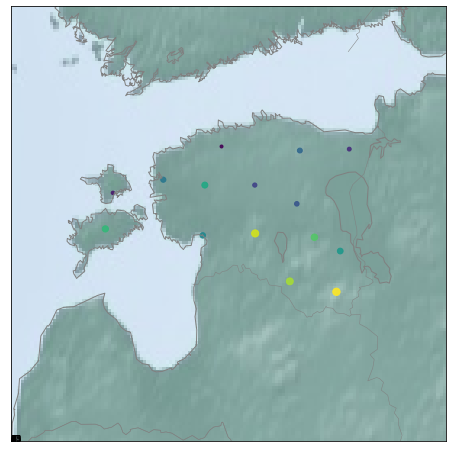

In [58]:
#Map the average county coordinates
#df_unique = df_fwe1.drop_duplicates(subset=['latitude', 'longitude'])
lat, lon, county = get_map_data(df_county_mean)
map_it(lat, lon, county)

In [59]:
#Add mean longitude and latitude using county id in weather forecast dataframe.
cols = df_county_mean.columns.tolist()
df_fwe1 = pd.merge(df_fwe1, df_county_mean[cols], on=['county'], how='left')

cols = cols + [col for col in df_fwe1.columns if not col in cols]

df_fwe1 = df_fwe1[cols]
df_fwe1['county']= df_fwe1['county'].apply(np.int64)
df_fwe1.head()

,m_latitude,m_longitude,county,datetime,m_temperature,m_dewpoint,rain,m_snowfall,surface_pressure,m_cloudcover_total,...,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.78,27.1,15,2021-09-01 03:00:00,11.6,10.4,0.0,0.0,998.2,61,...,0.003006,0.026001,1.048755,-2.526303,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.78,27.1,15,2021-09-01 03:00:00,11.9,11.0,0.0,0.0,988.4,98,...,0.000000,0.761780,1.183276,-3.873715,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.90,26.2,13,2021-09-01 03:00:00,11.6,9.9,0.0,0.0,1004.9,68,...,0.066223,0.332809,1.523974,-2.439878,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.78,27.1,15,2021-09-01 03:00:00,11.3,9.8,0.0,0.0,997.3,34,...,0.032730,0.105255,1.262256,-2.455014,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.78,27.1,15,2021-09-01 03:00:00,11.9,10.7,0.0,0.0,999.0,34,...,0.004593,0.133881,1.588183,-2.117612,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


In [60]:
#THIS WORKS NOW!!!! data block id not matching OFFSET of 2, why???????
df['date'] = pd.to_datetime(df['date'])
df_client['date'] = pd.to_datetime(df_client['date'])
df = pd.merge(df, df_client[['eic_count','installed_capacity','county','is_business','product_type','date']], left_on=['county','is_business','product_type','date'], right_on=['county','is_business','product_type','date'], how='left')
df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,datetime-1d,date,time,eic_count,installed_capacity
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-08-31,2021-09-01,0,108.0,952.89
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-08-31,2021-09-01,0,108.0,952.89
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021-08-31,2021-09-01,0,17.0,166.40
3,0,0,2,17.314,1,2021-09-01,0,3,1,2021-08-31,2021-09-01,0,17.0,166.40
4,0,0,3,2.904,0,2021-09-01,0,4,2,2021-08-31,2021-09-01,0,688.0,7207.88


In [61]:
#Fill in the missing eic_count values with next available one.
# Ensure 'date' is a datetime object
df['datetime'] = pd.to_datetime(df['datetime'])

# Iterate over rows with missing 'eic_count'
for index, row in df[df['eic_count'].isna()].iterrows():
    # Extract criteria
    county, is_business, product_type = row['county'], row['is_business'], row['product_type']
    
    # Find earliest date where data is available
    fill_data = df[(df['county'] == county) & 
                   (df['is_business'] == is_business) & 
                   (df['product_type'] == product_type) & 
                   (~df['eic_count'].isna())].sort_values('datetime').iloc[0]['eic_count']
    
    # Fill the missing data
    df.at[index, 'eic_count'] = fill_data

In [62]:
#Fill in the missing installed_capacity values with next available one.
# Ensure 'date' is a datetime object
df['datetime'] = pd.to_datetime(df['datetime'])

# Iterate over rows with missing 'eic_count'
for index, row in df[df['installed_capacity'].isna()].iterrows():
    # Extract criteria
    county, is_business, product_type = row['county'], row['is_business'], row['product_type']
    
    # Find earliest date where data is available
    fill_data = df[(df['county'] == county) & 
                   (df['is_business'] == is_business) & 
                   (df['product_type'] == product_type) & 
                   (~df['installed_capacity'].isna())].sort_values('datetime').iloc[0]['installed_capacity']
    
    # Fill the missing data
    df.at[index, 'installed_capacity'] = fill_data

In [63]:
df_fwe1.shape

(748230, 37)

In [64]:
# Convert the columns to sets and find the intersection
common_values = set(df['datetime']) & set(df_fwe1['forecast_datetime'])

# Count the number of common elements
num_common_values = len(common_values)

print(f"Number of common values (same as total hours): {num_common_values}")
#print(f"Common values: {common_values}")


Number of common values (same as total hours): 0


In [65]:
# Create composite keys for each dataframe
comp_key_df1 = set(df.apply(lambda row: f"{row['county']}-{row['datetime']}", axis=1))
comp_key_df2 = set(df_fwe1.apply(lambda row: f"{row['county']}-{row['forecast_datetime']}", axis=1))

# Find the intersection of these sets
common_comp_keys = comp_key_df1 & comp_key_df2

# Count the number of common elements
num_common_combinations = len(common_comp_keys)

print(f"Number of common county+date combinations: {num_common_combinations}")
#print(f"Common county+date combinations: {common_comp_keys}")


Number of common county+date combinations: 229050


In [66]:
#Create dataframe with using county mean coordinates to create mean measurement data for each county at each hour
df_fwe1['forecast_datetime'] = pd.to_datetime(df_fwe1['forecast_datetime'])
df_fwe1['datetime'] = pd.to_datetime(df_fwe1['datetime'])
df_fwe1['origin_datetime'] = pd.to_datetime(df_fwe1['origin_datetime'])
averaged_fwe = df_fwe1.groupby(['m_latitude', 'm_longitude', 'forecast_datetime']).mean().reset_index()

In [67]:
averaged_fwe.head()

,m_latitude,m_longitude,forecast_datetime,county,datetime,m_temperature,m_dewpoint,rain,m_snowfall,surface_pressure,...,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.78,27.1,2021-09-01 03:00:00,15.0,2021-09-01 03:00:00,11.94,10.74,0.0,0.0,997.10,...,0.079016,0.008447,0.374545,1.386011,-2.859360,1.0,0.000000,0.000000,0.0,0.000000e+00
1,57.78,27.1,2021-09-01 04:00:00,15.0,2021-09-01 04:00:00,11.44,10.16,0.0,0.0,997.00,...,0.110358,0.070035,0.231653,1.785885,-2.096934,1.0,0.000000,0.000000,0.0,-1.609325e-07
2,57.78,27.1,2021-09-01 05:00:00,15.0,2021-09-01 05:00:00,10.76,9.58,0.0,0.0,996.88,...,0.330560,0.261267,0.507678,2.249629,-1.966241,1.0,0.000000,0.000000,0.0,1.090765e-06
3,57.78,27.1,2021-09-01 06:00:00,15.0,2021-09-01 06:00:00,10.72,9.48,0.0,0.0,996.42,...,0.588104,0.506897,0.695679,2.464427,-2.375025,1.0,50.496000,12.234083,0.0,3.492832e-06
4,57.78,27.1,2021-09-01 07:00:00,15.0,2021-09-01 07:00:00,11.70,10.16,0.0,0.0,996.64,...,0.329041,0.334265,0.412271,2.333696,-2.858857,1.0,115.134719,63.964542,0.0,6.151199e-06


In [68]:
#229650 ok shappe
averaged_fwe.shape

(229050, 37)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   county              int64         
 1   is_business         int64         
 2   product_type        int64         
 3   target              float64       
 4   is_consumption      int64         
 5   datetime            datetime64[ns]
 6   data_block_id       int64         
 7   row_id              int64         
 8   prediction_unit_id  int64         
 9   datetime-1d         datetime64[ns]
 10  date                datetime64[ns]
 11  time                int32         
 12  eic_count           float64       
 13  installed_capacity  float64       
dtypes: datetime64[ns](3), float64(3), int32(1), int64(7)
memory usage: 207.9 MB


In [70]:
# Assuming df and df2 are your DataFrames
columns_df1 = set(df.columns)
columns_df2 = set(averaged_fwe.columns)

# Find the common columns
common_columns = columns_df1.intersection(columns_df2)

# Find the unique columns in both dataframes
unique_df1 = columns_df1 - common_columns
unique_df2 = columns_df2 - common_columns

# Combine the unique columns with the common columns as the merge basis
final_columns_df1 = list(unique_df1) + list(common_columns)
final_columns_df2 = list(unique_df2) + list(common_columns)


In [71]:
#Create keys to merge two dataframes to one.
left_list = list(common_columns)
left_list.append('datetime')
right_list = list(common_columns)
right_list.append('forecast_datetime')

In [72]:
df[final_columns_df1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   target              float64       
 1   is_business         int64         
 2   installed_capacity  float64       
 3   datetime-1d         datetime64[ns]
 4   date                datetime64[ns]
 5   is_consumption      int64         
 6   row_id              int64         
 7   product_type        int64         
 8   time                int32         
 9   eic_count           float64       
 10  prediction_unit_id  int64         
 11  county              int64         
 12  data_block_id       int64         
 13  datetime            datetime64[ns]
dtypes: datetime64[ns](3), float64(3), int32(1), int64(7)
memory usage: 207.9 MB


In [73]:
averaged_fwe[final_columns_df2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229050 entries, 0 to 229049
Data columns (total 37 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   latitude                           229050 non-null  float64       
 1   temperature                        229050 non-null  float64       
 2   surface_pressure                   229050 non-null  float64       
 3   m_longitude                        229050 non-null  float64       
 4   winddirection_10m                  229050 non-null  float64       
 5   diffuse_radiation                  229050 non-null  float64       
 6   cloudcover_total                   229050 non-null  float64       
 7   total_precipitation                229050 non-null  float64       
 8   m_cloudcover_low                   229050 non-null  float64       
 9   longitude                          229050 non-null  float64       
 10  snowfall            

In [74]:
#Convert key datatype to match on both dataframes.
averaged_fwe['data_block_id']= averaged_fwe['data_block_id'].apply(np.int64)
averaged_fwe['county']= averaged_fwe['county'].apply(np.int64)

In [75]:
# Merging the dataframes using only the unique columns
merged_df = pd.merge(df[final_columns_df1], averaged_fwe[final_columns_df2], left_on=left_list, right_on=right_list)

In [76]:
#NEED TO FIGURE OUT WHAT IS RIGHT SHAPE!!!
merged_df.shape

(1770642, 48)

In [77]:
df_dates = pd.read_csv("predict-energy-behavior-of-prosumers/s_date.csv")
df_dates.head()

,Date,English Name
0,1/1,New Year's Day
1,2/24,Independence Day
2,5/1,Spring Day
3,6/23,Victory Day
4,6/24,Midsummer Day


In [78]:
df_dates['Date'] = pd.to_datetime(df_dates['Date'].str.strip(), format='%m/%d')
df_dates['month_day'] = df_dates['Date'].dt.strftime('%m-%d')
df_dates.drop(['Date'], axis=1, inplace=True)
df_dates.head()

,English Name,month_day
0,New Year's Day,01-01
1,Independence Day,02-24
2,Spring Day,05-01
3,Victory Day,06-23
4,Midsummer Day,06-24


In [79]:
# Create the binary column based on month-day match
merged_df['month_day'] = merged_df['date'].dt.strftime('%m-%d')
merged_df['hol_date'] = merged_df['month_day'].isin(df_dates['month_day']).astype(int)
merged_df.drop(['month_day'], axis=1, inplace=True)
merged_df.head()

,target,is_business,installed_capacity,datetime-1d,date,is_consumption,row_id,product_type,time,eic_count,...,surface_solar_radiation_downwards,dewpoint,m_dewpoint,m_latitude,m_cloudcover_mid,forecast_datetime,m_cloudcover_high,cloudcover_low,direct_solar_radiation,hol_date
0,1.687,0,952.89,2021-09-01,2021-09-02,0,2928,1,0,108.0,...,0.0,5.576298,5.433333,59.3,43.333333,2021-09-02,0.0,0.177399,0.0,0
1,109.366,0,952.89,2021-09-01,2021-09-02,1,2929,1,0,108.0,...,0.0,5.576298,5.433333,59.3,43.333333,2021-09-02,0.0,0.177399,0.0,0
2,0.000,0,166.40,2021-09-01,2021-09-02,0,2930,2,0,17.0,...,0.0,5.576298,5.433333,59.3,43.333333,2021-09-02,0.0,0.177399,0.0,0
3,21.008,0,166.40,2021-09-01,2021-09-02,1,2931,2,0,17.0,...,0.0,5.576298,5.433333,59.3,43.333333,2021-09-02,0.0,0.177399,0.0,0
4,1.003,0,7207.88,2021-09-01,2021-09-02,0,2932,3,0,688.0,...,0.0,5.576298,5.433333,59.3,43.333333,2021-09-02,0.0,0.177399,0.0,0


In [80]:
merged_df.isnull().sum()

target                               258
is_business                            0
installed_capacity                     0
datetime-1d                            0
date                                   0
is_consumption                         0
row_id                                 0
product_type                           0
time                                   0
eic_count                              0
prediction_unit_id                     0
county                                 0
data_block_id                          0
datetime                               0
latitude                               0
temperature                            0
surface_pressure                       0
m_longitude                            0
winddirection_10m                      0
diffuse_radiation                      0
cloudcover_total                       0
total_precipitation                    0
m_cloudcover_low                       0
longitude                              0
snowfall        

In [81]:
# Ensure 'date' is a datetime object
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Iterate over rows with missing 'target'
for index, row in merged_df[merged_df['target'].isna()].iterrows():
    # Extract criteria
    county, is_business, product_type = row['county'], row['is_business'], row['product_type']
    
    # Find rows matching the criteria
    criteria_df = merged_df[(merged_df['county'] == county) & 
                            (merged_df['is_business'] == is_business) & 
                            (merged_df['product_type'] == product_type) & 
                            (~merged_df['target'].isna())]
    
    # Find the previous and next available 'target' values
    prev_value = criteria_df[criteria_df['date'] < row['date']].sort_values('date', ascending=False).iloc[0]['target']
    next_value = criteria_df[criteria_df['date'] > row['date']].sort_values('date').iloc[0]['target']
    
    # Calculate average
    avg_value = (prev_value + next_value) / 2
    
    # Fill the missing data
    merged_df.at[index, 'target'] = avg_value

In [82]:
merged_df.loc[merged_df['target'].isnull()]

,target,is_business,installed_capacity,datetime-1d,date,is_consumption,row_id,product_type,time,eic_count,...,surface_solar_radiation_downwards,dewpoint,m_dewpoint,m_latitude,m_cloudcover_mid,forecast_datetime,m_cloudcover_high,cloudcover_low,direct_solar_radiation,hol_date


In [83]:
df.shape[0] - merged_df.shape[0]

247710

In [84]:
#Join train and gas price data. Check if works properly
merged_df['date'] = pd.to_datetime(merged_df['date'])
df_merged = pd.merge(merged_df, df_gas[['forecast_date', 'lowest_price_per_mwh','highest_price_per_mwh']], left_on='date', right_on='forecast_date', how='left')
df_merged = df_merged.drop('forecast_date', axis=1)
df_merged.head()

,target,is_business,installed_capacity,datetime-1d,date,is_consumption,row_id,product_type,time,eic_count,...,m_dewpoint,m_latitude,m_cloudcover_mid,forecast_datetime,m_cloudcover_high,cloudcover_low,direct_solar_radiation,hol_date,lowest_price_per_mwh,highest_price_per_mwh
0,1.687,0,952.89,2021-09-01,2021-09-02,0,2928,1,0,108.0,...,5.433333,59.3,43.333333,2021-09-02,0.0,0.177399,0.0,0,45.62,46.29
1,109.366,0,952.89,2021-09-01,2021-09-02,1,2929,1,0,108.0,...,5.433333,59.3,43.333333,2021-09-02,0.0,0.177399,0.0,0,45.62,46.29
2,0.000,0,166.40,2021-09-01,2021-09-02,0,2930,2,0,17.0,...,5.433333,59.3,43.333333,2021-09-02,0.0,0.177399,0.0,0,45.62,46.29
3,21.008,0,166.40,2021-09-01,2021-09-02,1,2931,2,0,17.0,...,5.433333,59.3,43.333333,2021-09-02,0.0,0.177399,0.0,0,45.62,46.29
4,1.003,0,7207.88,2021-09-01,2021-09-02,0,2932,3,0,688.0,...,5.433333,59.3,43.333333,2021-09-02,0.0,0.177399,0.0,0,45.62,46.29


In [85]:
df_el.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   forecast_date  15286 non-null  object        
 1   euros_per_mwh  15286 non-null  float64       
 2   origin_date    15286 non-null  datetime64[ns]
 3   data_block_id  15286 non-null  int64         
 4   time           15286 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(1)
memory usage: 537.5+ KB


In [86]:
#Join train and electricity price data. Use data_block_id and time of the day for join.Useforecast and datetime, need to rename column names same first

df_el['forecast_datetime'] = pd.to_datetime(df_el['forecast_date'])
df_merged = pd.merge(df_merged, df_el[['euros_per_mwh', 'forecast_datetime']], on='forecast_datetime', how='left')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1770642 entries, 0 to 1770641
Data columns (total 52 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   target                             float64       
 1   is_business                        int64         
 2   installed_capacity                 float64       
 3   datetime-1d                        datetime64[ns]
 4   date                               datetime64[ns]
 5   is_consumption                     int64         
 6   row_id                             int64         
 7   product_type                       int64         
 8   time                               int32         
 9   eic_count                          float64       
 10  prediction_unit_id                 int64         
 11  county                             int64         
 12  data_block_id                      int64         
 13  datetime                           datetime64[ns]
 14  la

In [87]:
df_el.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id,time,forecast_datetime
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1,0,2021-09-01 00:00:00
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1,1,2021-09-01 01:00:00
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1,2,2021-09-01 02:00:00
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1,3,2021-09-01 03:00:00
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1,4,2021-09-01 04:00:00


In [88]:
df_merged['week_no'] = df_merged['date'].dt.isocalendar().week
df_merged['week_day'] = df_merged['date'].dt.isocalendar().day

In [89]:
df_merged.shape

(1770642, 54)

In [90]:
df_merged.isnull().sum()

target                                 0
is_business                            0
installed_capacity                     0
datetime-1d                            0
date                                   0
is_consumption                         0
row_id                                 0
product_type                           0
time                                   0
eic_count                              0
prediction_unit_id                     0
county                                 0
data_block_id                          0
datetime                               0
latitude                               0
temperature                            0
surface_pressure                       0
m_longitude                            0
winddirection_10m                      0
diffuse_radiation                      0
cloudcover_total                       0
total_precipitation                    0
m_cloudcover_low                       0
longitude                              0
snowfall        

In [91]:
#Fill the missing gas and electricity values
df_merged['highest_price_per_mwh'].ffill(inplace=True)
df_merged['lowest_price_per_mwh'].ffill(inplace=True)

In [92]:
df_merged.head()

,target,is_business,installed_capacity,datetime-1d,date,is_consumption,row_id,product_type,time,eic_count,...,forecast_datetime,m_cloudcover_high,cloudcover_low,direct_solar_radiation,hol_date,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,week_no,week_day
0,1.687,0,952.89,2021-09-01,2021-09-02,0,2928,1,0,108.0,...,2021-09-02,0.0,0.177399,0.0,0,45.62,46.29,96.99,35,4
1,109.366,0,952.89,2021-09-01,2021-09-02,1,2929,1,0,108.0,...,2021-09-02,0.0,0.177399,0.0,0,45.62,46.29,96.99,35,4
2,0.000,0,166.40,2021-09-01,2021-09-02,0,2930,2,0,17.0,...,2021-09-02,0.0,0.177399,0.0,0,45.62,46.29,96.99,35,4
3,21.008,0,166.40,2021-09-01,2021-09-02,1,2931,2,0,17.0,...,2021-09-02,0.0,0.177399,0.0,0,45.62,46.29,96.99,35,4
4,1.003,0,7207.88,2021-09-01,2021-09-02,0,2932,3,0,688.0,...,2021-09-02,0.0,0.177399,0.0,0,45.62,46.29,96.99,35,4


In [93]:
#MISSING label values. DO WE WANT TO FILL THESE OR JUST DROP THEM???? Analyze what is missing
# df_merged['target'].interpolate(inplace=True)

In [94]:
df_merged[['datetime','product_type','target','prediction_unit_id','installed_capacity']][df['target'].isnull()]

/tmp/ipykernel_3086/464254944.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_merged[['datetime','product_type','target','prediction_unit_id','installed_capacity']][df['target'].isnull()]


,datetime,product_type,target,prediction_unit_id,installed_capacity
178938,2021-11-10 03:00:00,3,0.004,48,5703.4
178939,2021-11-10 03:00:00,3,3435.510,48,5703.4
178940,2021-11-10 03:00:00,1,0.000,50,136.2
178941,2021-11-10 03:00:00,1,11.305,50,136.2
178942,2021-11-10 03:00:00,3,0.000,51,610.4
...,...,...,...,...,...
1332587,2022-12-26 04:00:00,3,920.165,42,2268.4
1332588,2022-12-26 04:00:00,1,0.000,43,1423.7
1332589,2022-12-26 04:00:00,1,280.927,43,1423.7
1332590,2022-12-26 04:00:00,2,0.000,44,58.0


In [95]:
df_merged[['datetime']][df['target'].isnull()].nunique()

/tmp/ipykernel_3086/2664690533.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_merged[['datetime']][df['target'].isnull()].nunique()


datetime    6
dtype: int64

# Visualize the data

In [96]:
df_merged['euros_per_mwh'].interpolate(inplace=True)

<Figure size 1296x720 with 0 Axes>

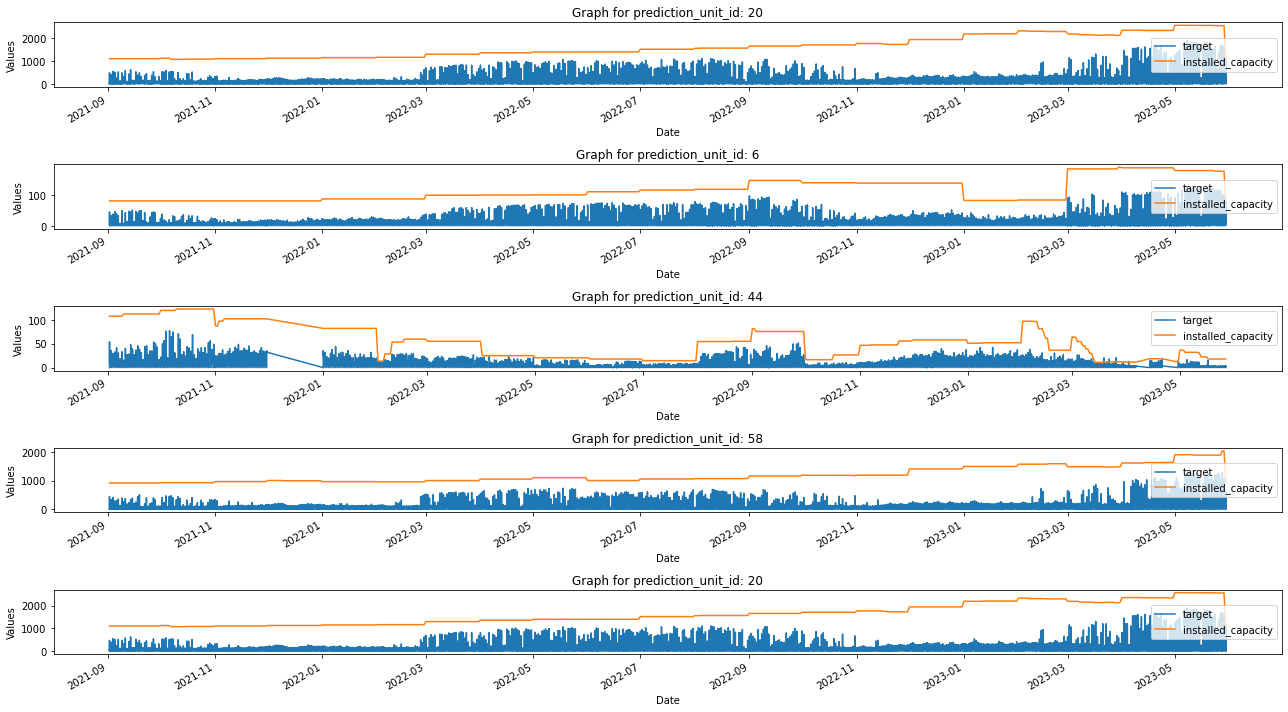

In [97]:
#Let's plot five random customers, installed_capacity and target

plt.figure(figsize=(18, 10))
x = 0

df_merged.set_index('date', inplace=True)

plt.figure(figsize=(18, 10))

# Generate 5 random 'ix' values and plot separate graphs
for i in range(5):
    ix = random.randint(0, 68)
    plt.subplot(5, 1, i + 1)  # Create a subplot for each graph
    df_merged['target'][df_merged['prediction_unit_id'] == ix].plot(x='date', y='target', label='target')
    df_merged['installed_capacity'][df_merged['prediction_unit_id'] == ix].plot(x='date', y='installed_capacity', label='installed_capacity')
    plt.title(f'Graph for prediction_unit_id: {ix}')
    plt.legend()
    plt.ylabel('Values')
    plt.xlabel('Date')

df_merged.reset_index('date', inplace=True)
plt.tight_layout()
plt.show()

In [98]:
#Missing eic_count rows (and capacity installed). Fill with earliest future date values.
df[['county','is_business','product_type','data_block_id']][df['eic_count'].isna()]

,county,is_business,product_type,data_block_id


In [99]:
df.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id',
       'datetime-1d', 'date', 'time', 'eic_count', 'installed_capacity'],
      dtype='object')

# Let's map it

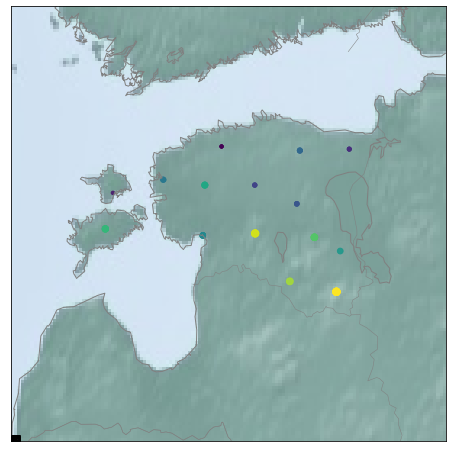

In [100]:
#Map the weather stations with county assignment, NO NEED
df_unique = df_fwe1.drop_duplicates(subset=['latitude', 'longitude'])
lat, lon, county = get_map_data(df_unique)
map_it(lat,lon,county)

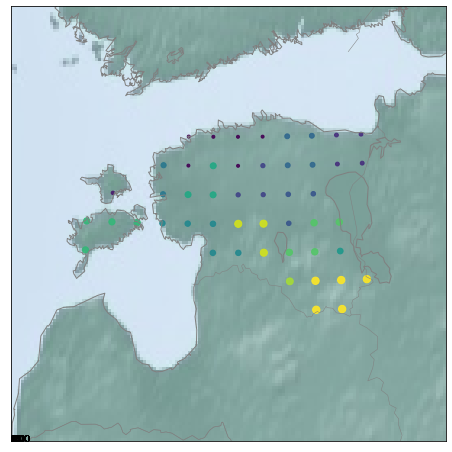

In [101]:
#Map all the weather forcast locations with county coloring
lat, lon, county = get_map_data(df_wcmap)
map_it(lat,lon,county)

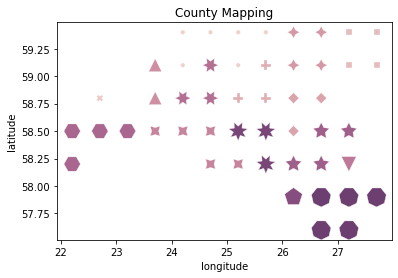

In [102]:
sns.scatterplot(data=df_unique, x='longitude', y='latitude', hue='county', size='county', sizes=(20,400), hue_norm=(0, 20), style="county", legend=False)
plt.title('County Mapping')
plt.show()

In [103]:
df_merged.columns

Index(['date', 'target', 'is_business', 'installed_capacity', 'datetime-1d',
       'is_consumption', 'row_id', 'product_type', 'time', 'eic_count',
       'prediction_unit_id', 'county', 'data_block_id', 'datetime', 'latitude',
       'temperature', 'surface_pressure', 'm_longitude', 'winddirection_10m',
       'diffuse_radiation', 'cloudcover_total', 'total_precipitation',
       'm_cloudcover_low', 'longitude', 'snowfall', 'cloudcover_high',
       'cloudcover_mid', 'm_snowfall', 'hours_ahead',
       'm_direct_solar_radiation', 'm_temperature', 'm_data_block_id',
       '10_metre_v_wind_component', 'shortwave_radiation',
       '10_metre_u_wind_component', 'm_cloudcover_total', 'rain',
       'windspeed_10m', 'origin_datetime', 'surface_solar_radiation_downwards',
       'dewpoint', 'm_dewpoint', 'm_latitude', 'm_cloudcover_mid',
       'forecast_datetime', 'm_cloudcover_high', 'cloudcover_low',
       'direct_solar_radiation', 'hol_date', 'lowest_price_per_mwh',
       'highest_pr

In [104]:
dates = df_merged['date']
df_merged['target'] = df_merged.pop('target')
df_merged.drop(['row_id', 'datetime-1d', 'datetime', 'origin_datetime', 'forecast_datetime','m_longitude', 'm_latitude', 'm_data_block_id', 'data_block_id'], axis=1, inplace=True)
df_merged.head()

,date,is_business,installed_capacity,is_consumption,product_type,time,eic_count,prediction_unit_id,county,latitude,...,m_cloudcover_high,cloudcover_low,direct_solar_radiation,hol_date,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,week_no,week_day,target
0,2021-09-02,0,952.89,0,1,0,108.0,0,0,59.3,...,0.0,0.177399,0.0,0,45.62,46.29,96.99,35,4,1.687
1,2021-09-02,0,952.89,1,1,0,108.0,0,0,59.3,...,0.0,0.177399,0.0,0,45.62,46.29,96.99,35,4,109.366
2,2021-09-02,0,166.40,0,2,0,17.0,1,0,59.3,...,0.0,0.177399,0.0,0,45.62,46.29,96.99,35,4,0.000
3,2021-09-02,0,166.40,1,2,0,17.0,1,0,59.3,...,0.0,0.177399,0.0,0,45.62,46.29,96.99,35,4,21.008
4,2021-09-02,0,7207.88,0,3,0,688.0,2,0,59.3,...,0.0,0.177399,0.0,0,45.62,46.29,96.99,35,4,1.003


<AxesSubplot:>

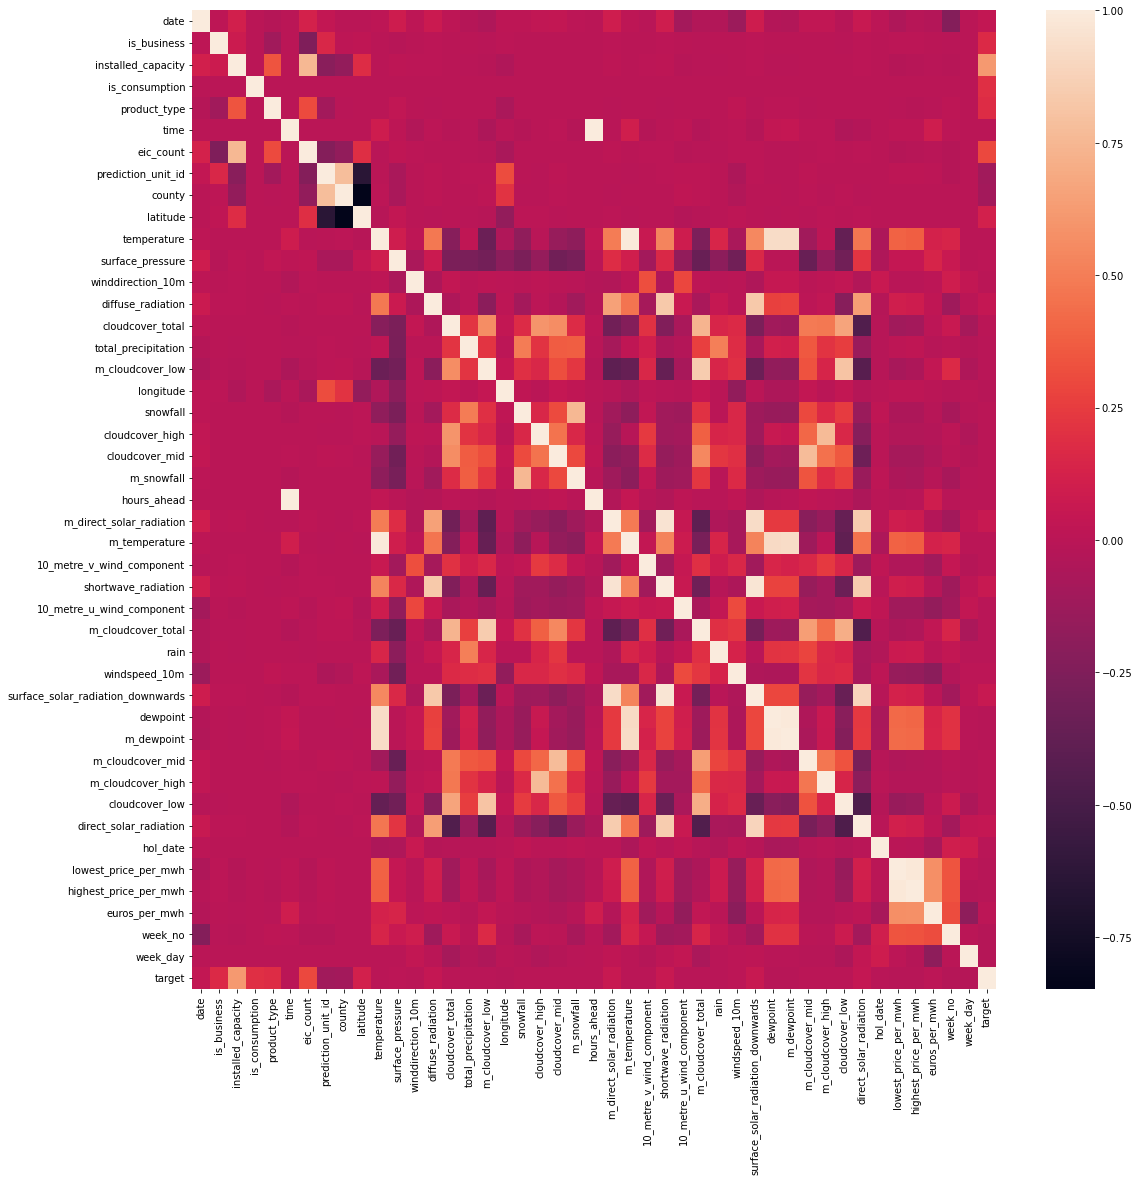

In [105]:
plt.figure(figsize=(18, 18))
corr = df_merged.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [106]:
#plt.figure(figsize=(18, 18))
#sns.pairplot(df_merged.iloc[:,1:10])

# Set your correlation threshold
correlation_threshold = 0.0  # Example threshold

# Assuming the name of your target column is 'target'
# Calculate the correlation with the target
correlation_with_target = df_merged.corr()['target'].abs()

# Identify columns below the threshold
columns_to_drop = correlation_with_target[correlation_with_target < correlation_threshold].index

# Drop these columns
df_final = df_merged.drop(columns=columns_to_drop)

# Now df_merged has only the features with a correlation above the threshold


In [107]:
# Assuming df_merged is your DataFrame
corr = df_merged.corr()

# Create a DataFrame from the correlation matrix, stack it, and reset index
corr_df = corr.stack().reset_index()
corr_df.columns = ['Feature1', 'Feature2', 'Correlation']

# Remove self-correlation (correlation of features with themselves)
corr_df = corr_df[corr_df['Feature1'] != corr_df['Feature2']]

#Get absolute values for correlation
corr_df['Abs_Correlation'] = corr_df['Correlation'].abs()

#Sort by highest absolute correlation
corr_df_sorted = corr_df.sort_values(by='Abs_Correlation', ascending=False)

#Get top 5 pairs
top_pairs = corr_df_sorted.head(10)
print(top_pairs)

#If you want to drop one feature from each highly correlated pair
#features_to_drop = set()
#for _, row in top_5_pairs.iterrows():

                               Feature1                           Feature2  \
247                                time                        hours_ahead   
995                         hours_ahead                               time   
1090                      m_temperature                        temperature   
474                         temperature                      m_temperature   
1473                           dewpoint                         m_dewpoint   
1517                         m_dewpoint                           dewpoint   
1795               lowest_price_per_mwh              highest_price_per_mwh   
1839              highest_price_per_mwh               lowest_price_per_mwh   
1421  surface_solar_radiation_downwards                shortwave_radiation   
1201                shortwave_radiation  surface_solar_radiation_downwards   

      Correlation  Abs_Correlation  
247      0.996758         0.996758  
995      0.996758         0.996758  
1090     0.992565         0.99

In [108]:
correlation_with_target

date                                 0.038574
is_business                          0.164432
installed_capacity                   0.613619
is_consumption                       0.196198
product_type                         0.178364
time                                 0.003358
eic_count                            0.296601
prediction_unit_id                   0.109445
county                               0.098879
latitude                             0.112965
temperature                          0.000322
surface_pressure                     0.006394
winddirection_10m                    0.000690
diffuse_radiation                    0.044753
cloudcover_total                     0.002153
total_precipitation                  0.004645
m_cloudcover_low                     0.004125
longitude                            0.012131
snowfall                             0.003816
cloudcover_high                      0.001450
cloudcover_mid                       0.000006
m_snowfall                        

In [109]:
df_merged.isnull().sum()

date                                 0
is_business                          0
installed_capacity                   0
is_consumption                       0
product_type                         0
time                                 0
eic_count                            0
prediction_unit_id                   0
county                               0
latitude                             0
temperature                          0
surface_pressure                     0
winddirection_10m                    0
diffuse_radiation                    0
cloudcover_total                     0
total_precipitation                  0
m_cloudcover_low                     0
longitude                            0
snowfall                             0
cloudcover_high                      0
cloudcover_mid                       0
m_snowfall                           0
hours_ahead                          0
m_direct_solar_radiation             0
m_temperature                        0
10_metre_v_wind_component

In [110]:
#n_customers = df_merged['prediction_unit_id'].nunique()
#n_customers = 68
df_merged.drop(['prediction_unit_id'], axis=1, inplace=True)

### Scale the data

In [111]:
#Scale and normalize the features for LSTM. Not tested!!!
rows, columns = df_merged.shape
#rows, columns = df_final.shape
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaler = RobustScaler()

scaled = scaler.fit_transform(df_merged.iloc[:,1:columns-1].values)
all_data = pd.concat([pd.DataFrame(dates), pd.DataFrame(scaled), df_merged['target']], axis=1)
#all_data = pd.concat([pd.DataFrame(dates), pd.DataFrame(scaled)], axis=1)
all_data.head()

,date,0,1,2,3,4,5,6,7,8,...,33,34,35,36,37,38,39,40,41,target
0,2021-09-02,-1.0,0.236542,-0.5,-0.5,-1.181818,1.333333,-0.875,1.0,0.488263,...,-0.167611,-0.157694,-0.003131,0.0,-0.816735,-0.749332,-0.323276,0.37931,0.0,1.687
1,2021-09-02,-1.0,0.236542,0.5,-0.5,-1.181818,1.333333,-0.875,1.0,0.488263,...,-0.167611,-0.157694,-0.003131,0.0,-0.816735,-0.749332,-0.323276,0.37931,0.0,109.366
2,2021-09-02,-1.0,-0.392198,-0.5,0.0,-1.181818,-0.263158,-0.875,1.0,0.488263,...,-0.167611,-0.157694,-0.003131,0.0,-0.816735,-0.749332,-0.323276,0.37931,0.0,0.000
3,2021-09-02,-1.0,-0.392198,0.5,0.0,-1.181818,-0.263158,-0.875,1.0,0.488263,...,-0.167611,-0.157694,-0.003131,0.0,-0.816735,-0.749332,-0.323276,0.37931,0.0,21.008
4,2021-09-02,-1.0,5.236933,-0.5,0.5,-1.181818,11.508772,-0.875,1.0,0.488263,...,-0.167611,-0.157694,-0.003131,0.0,-0.816735,-0.749332,-0.323276,0.37931,0.0,1.003


### Split the data

In [112]:
all_data.shape

(1770642, 44)

In [135]:
values = all_data.iloc[:,1:].values.astype('float32') # get data in correct format
X, y = values[:, 0:-1], values[:, -1]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42 )

In [137]:
# Check if there are any NaNs in the dataset
if np.isnan(train_y).any():
    print("NaN values found in train_X")
    #train_y = np.nan_to_num(train_y)  # Replace NaNs with 0 (or other appropriate values)

# Check for infinite values
if np.isinf(train_y).any():
    print("Infinite values found in train_X")
    #train_y = np.clip(train_y, a_min=-np.inf, a_max=np.inf)  # Replace infinities with large finite numbers

In [136]:
train_y.shape

(1186330,)

In [ ]:
X, y = values[:, 1:-1], values[:, -1]

In [ ]:
#MLPRegressor running on CPU, slow with high number of iterations.

#with config_context(target_offload="gpu:1"): #DOES NOT WORK WITH MLPRegressor
regr = MLPRegressor(random_state=24,
                        max_iter=70, 
                        hidden_layer_sizes=(400,250,10), #220,100,10
                        early_stopping=True,
                        batch_size='auto',
                        learning_rate='adaptive',
                        alpha=0.0002,
                        solver='adam',
                        verbose=True).fit(train_X, train_y)
   
score1 = regr.score(train_X, train_y)
print('Score:', score1)

In [ ]:
#Only when MLPregressor is active model
plt.plot(regr.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [ ]:
y_pred = regr.predict(test_X)
#y_pred = np.maximum(y_pred, 0)
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

In [ ]:
#Transfer data in GPU
pip install cupy-cuda12x

import cupy as cp
train_X = cp.array(train_X)
test_X =cp.array(test_X)

In [138]:
#XGBRegressor using GPU

regr = XGBRegressor(n_estimators=10000, #increasing this no benefits on accuracy
                    max_depth=6, # 5 to 3 got worse, 6 0.94/0.04
                    eta=0.02, #0.02 to 0.005 NO IMPACT, making it very low not good
                    tree_method='hist',
                    max_bin = 36, # 48 to 64 GOT WORSE, 64 to 36 no major impact
                    objective ='reg:squarederror',
                    seed = 12,
                    #sampling_method = 'gradient_based', #keep it default
                    reg_lambda = 1.5, #this is the last change from 0.5 to 0.3, NO IMPACT
                    device='cuda', 
                    eval_metric='mae',
                    verbosity=0).fit(train_X, train_y)               
scores = cross_val_score(regr, test_X, test_y, cv=5, n_jobs=-1, verbose=0)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())) 

y_pred = regr.predict(test_X)
y_pred = np.maximum(y_pred, 0)

print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

0.99 accuracy with a standard deviation of 0.00
Mean Absolute Error: 36.146133
Mean Squared Error: 9527.539
Root Mean Squared Error: 97.609116


6171.684


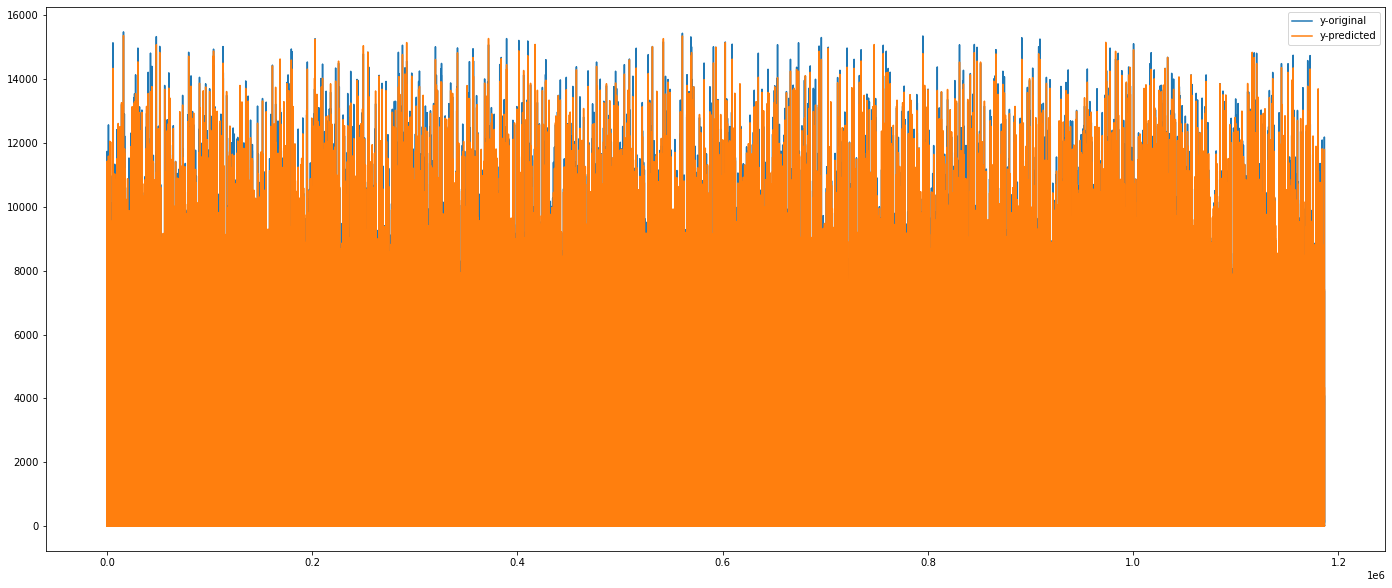

In [139]:
plt.figure(figsize=(24, 10))

y_pred = regr.predict(train_X)
y_pred = np.maximum(y_pred, 0)
mse_krr = mean_squared_error(train_y, y_pred)
print(mse_krr)
plt.plot(train_y, label="y-original")
plt.plot(y_pred, label="y-predicted")
plt.legend()
plt.show()

9527.539


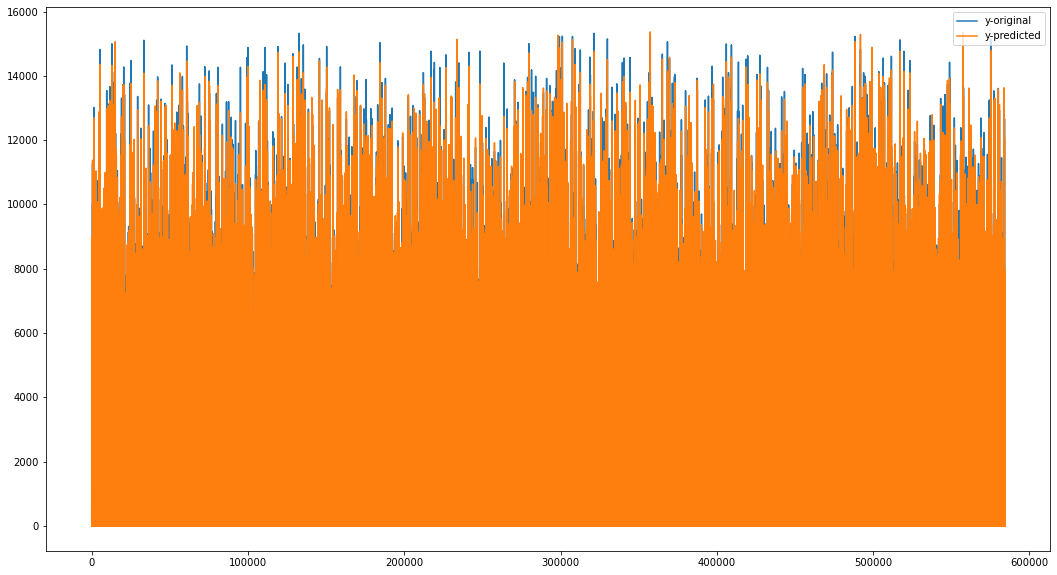

In [140]:
plt.figure(figsize=(18, 10))

y_pred = regr.predict(test_X)
y_pred = np.maximum(y_pred, 0)
mse_krr = mean_squared_error(test_y, y_pred)
print(mse_krr)
plt.plot(test_y, label="y-original")
plt.plot(y_pred, label="y-predicted")
plt.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go

# Assuming y_pred and test_y are available from your previous code

# Create a Plotly figure
fig = go.Figure()

# Add original y (test_y) as a trace
fig.add_trace(go.Scatter(y=test_y, mode='lines', name='y-original'))

# Add predicted y (y_pred) as another trace
fig.add_trace(go.Scatter(y=y_pred, mode='lines', name='y-predicted'))

# Update layout (optional)
fig.update_layout(title='Comparison of Original and Predicted Values',
                  xaxis_title='Index',
                  yaxis_title='Value')

# Show the interactive plot
fig.show()


In [142]:
# split into train and test sets, keep the timeseries order this time
values = all_data.iloc[:,1:].values.astype('float32') # get data in correct format
n_train_hours = round(0.7 * 638) * 24 * n_customers * 2
train = values[:n_train_hours, :]
test = values[n_train_hours:-58, :]
# split into input and outputs
train_X, train_y = train[:, 0:-1], train[:, -1]
test_X, test_y = test[:, 0:-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1480464, 42) (1480464,) (290120, 42) (290120,)


In [ ]:
#Plot the time series test data

y_pred = regr.predict(test_X)
y_pred = np.maximum(y_pred, 0)

import plotly.graph_objects as go

# Assuming y_pred and test_y are available from your previous code

# Create a Plotly figure
fig = go.Figure()

# Add original y (test_y) as a trace
fig.add_trace(go.Scatter(y=test_y, mode='lines', name='y-original'))

# Add predicted y (y_pred) as another trace
fig.add_trace(go.Scatter(y=y_pred, mode='lines', name='y-predicted'))

# Update layout (optional)
fig.update_layout(title='Comparison of Original and Predicted Values',
                  xaxis_title='Index',
                  yaxis_title='Value')

# Show the interactive plot
fig.show()

10708.79


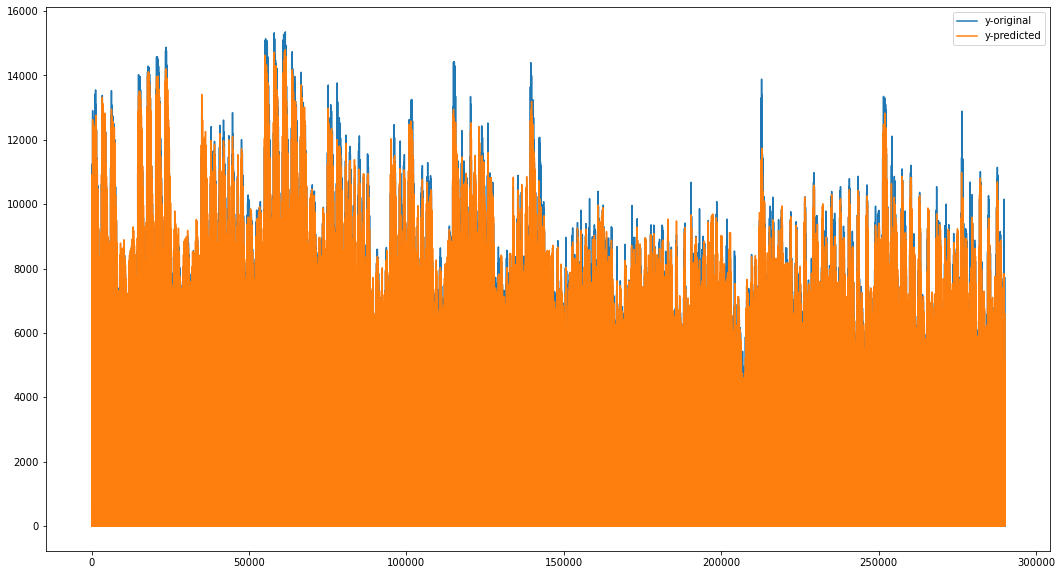

In [144]:
#Plot the time series test data

plt.figure(figsize=(18, 10))

y_pred = regr.predict(test_X)
y_pred = np.maximum(y_pred, 0)
mse_krr = mean_squared_error(test_y, y_pred)
print(mse_krr)
plt.plot(test_y, label="y-original")
plt.plot(y_pred, label="y-predicted")
plt.legend()
plt.show()

In [ ]:
filename = 'finalized_MLPreg_model_features_checked.sav'
pickle.dump(regr, open(filename, 'wb'))

In [ ]:
#filename = 'finalized_MLPreg_model_features_checked.sav'
#regr = pickle.load(open(filename, 'rb'))